In [1]:
import pandas as pd
import scipy.io.wavfile
import scipy.signal
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

speed_sound = 340.0

In [3]:
'''
Setting up the toy example:
Four Sensors are placed in a square five meters on a side

The Sources are placed 20 meters away at hours on a clock, e.g., every 30 degrees
'''
Sensor1 = [5,5]
Sensor2 = [5, -5]
Sensor3 = [-5, -5]
Sensor4 = [-5, 5]
Sensors = np.array([Sensor1, Sensor2, Sensor3, Sensor4])
Sources = np.array([[20 * np.cos(i * np.pi/6), 20 * np.sin(i * np.pi/6)] for i in range(12)])
#Sources = np.array([[90,90], [95,92], [87,90], [92,85]])
D = np.zeros((len(Sensors), len(Sources)))
for i in range(len(Sensors)):
    x = Sensors[i]
    for j in range(len(Sources)):
        a = Sources[j]
        D[i,j] = np.linalg.norm(x-a, 2)
#D[i,j] contains the time delay that sound from source j takes to reach Sensor i        

In [4]:
#dt is the relative delay, which reference to the first sensor given by Eq. 7 in SfS
T = D / speed_sound
dt = T[1:] - T[0,:]

In [5]:
#This implements Eq. 18 from SfS paper. 
#u, s, v are denoted u, v, w.transpose in SfS paper
u, s , v = np.linalg.svd(dt, full_matrices=True)
#As mentioned in SfS only need first two diagnol terms of s..
S = np.diag(s[:2])
#..and first two columns of w.transpose, which is first two rows of v
v = v[0:2,:]
#v = v
print(u)
print("--")
print(S)
print("--")
##-1 from Eq. 13 in SFS
print -1* speed_sound* np.matmul(u[:,:2],S)
print("--")
print(v)

[[ -4.10995638e-01   7.07106781e-01   5.75397763e-01]
 [ -8.13735320e-01   5.55111512e-17  -5.81235605e-01]
 [ -4.10995638e-01  -7.07106781e-01   5.75397763e-01]]
--
[[ 0.12302381  0.        ]
 [ 0.          0.07090803]]
--
[[  1.71911651e+01  -1.70474466e+01]
 [  3.40369993e+01  -1.33830337e-15]
 [  1.71911651e+01   1.70474466e+01]]
--
[[-0.28354    -0.41868845 -0.41868845 -0.28354    -0.08078671  0.12197628
   0.28354     0.37749888  0.37749888  0.28354     0.12197628 -0.08078671]
 [-0.28402228 -0.10155394  0.10155394  0.28402228  0.39877079  0.39877079
   0.28402228  0.10155394 -0.10155394 -0.28402228 -0.39877079 -0.39877079]]


In [6]:
print(np.rad2deg(np.arccos(v[0, :])))
print(np.rad2deg(np.arcsin(v[1, :])))

print((np.arccos(v[0, :])))
print((np.arcsin(v[1, :])))

[ 106.47159728  114.75181181  114.75181181  106.47159728   94.63378717
   82.99382693   73.52840272   67.8211565    67.8211565    73.52840272
   82.99382693   94.63378717]
[-16.50041437  -5.82865999   5.82865999  16.50041437  23.50135712
  23.50135712  16.50041437   5.82865999  -5.82865999 -16.50041437
 -23.50135712 -23.50135712]
[ 1.85827993  2.00279694  2.00279694  1.85827993  1.65167117  1.44851554
  1.28331272  1.18370248  1.18370248  1.28331272  1.44851554  1.65167117]
[-0.28798656 -0.10172931  0.10172931  0.28798656  0.41017606  0.41017606
  0.28798656  0.10172931 -0.10172931 -0.28798656 -0.41017606 -0.41017606]


In [7]:
#This is the cost function, which is the term trying to minimize in Eq. 22 of SfS
def Fx(c11, c12, c21, c22):
    X = ((c11**2 + c21**2) * v[0,:]**2) + ((c12**2 + c22**2) * v[1,:]**2)\
      + ((2*(c11*c12 + c21*c22))* (v[0]*v[1]))
    X = X - np.ones((X.shape))    
    return X

In [8]:
#This is the derivative of the cost function. 
#For simplicity each partial derivative is written separately. 
#The v matrix is not passed to this function, rather it is expected to be a global variable. 
def df(c11, c12, c21, c22):
    jc11 = 2.0 * ((c11 * (v[0, :]**2)) + (c12 * (v[0,:] * v[1,:])))
    jc12 = 2.0 * ((c12 * (v[1, :]**2)) + (c11 * (v[0,:] * v[1,:])))
    jc21 = 2.0 * ((c21 * (v[0, :]**2)) + (c22 * (v[0,:] * v[1,:])))
    jc22 = 2.0 * ((c22 * (v[1, :]**2)) + (c21 * (v[0,:] * v[1,:])))
    return (jc11, jc12, jc21, jc22)

In [9]:
#Initialize the C matrix (Eq. 20) to the identity matrix
C = np.eye(2)
c11 = C[0,0]
c12 = C[0,1]
c21 = C[1,0]
c22 = C[1,1]
#Set learning rate, max number of iterations, etc. 
#Have not really played around to see how these impact results. 
#i.e., can we get away with fewer iterations and converge 'close enough'
gamma = 0.05
precision = 1e-9
num_iter = 1000
it = 0
fvals = [100]
while it < num_iter and fvals[-1] > precision:
    it += 1
    #Compute cost function
    X = Fx(c11, c12, c21, c22)
    #Compute partial derivatives
    (jc11, jc12, jc21, jc22) = df(c11, c12, c21, c22)
    Jc = np.array([jc11, jc12, jc21, jc22])
    #fx is the gradient at the current step
    fx = np.matmul(Jc, X)
    c11 = c11 - gamma * fx[0]
    c12 = c12 - gamma * fx[1]
    c21 = c21 - gamma * fx[2]
    c22 = c22 - gamma * fx[3]
    #ffx is the current error. I don't think this is correct actually, this should only be a function of Fx I believe
    ffx = np.dot(fx, fx)
    fvals.append(ffx)
    print("iter: %s\tc11:%s, c12:%s, c21:%s, c22:%s\tFx:%s" % (it, c11, c12, c21, c22, fvals[-1]))

iter: 1	c11:1.08322388686, c12:5.89805981832e-18, c21:5.89805981832e-18, c22:1.08330936839	Fx:5.54666648213
iter: 2	c11:1.17022259878, c12:1.35308431126e-17, c21:1.38777878078e-17, c22:1.1704218321	Fx:6.06294288427
iter: 3	c11:1.26035853415, c12:2.18575157973e-17, c21:2.15105711021e-17, c22:1.26070530375	Fx:6.51023683858
iter: 4	c11:1.3528028673, c12:3.3653635434e-17, c21:3.33066907388e-17, c22:1.35333652819	Fx:6.85059938906
iter: 5	c11:1.44654232332, c12:4.6143644461e-17, c21:4.85722573274e-17, c22:1.44730741853	Fx:7.0470455384
iter: 6	c11:1.54040489307, c12:5.79397640976e-17, c21:5.79397640976e-17, c22:1.54145021691	Fx:7.06921939561
iter: 7	c11:1.63310674357, c12:6.83481049535e-17, c21:6.55725473919e-17, c22:1.63448378717	Fx:6.89955131181
iter: 8	c11:1.72331921641, c12:7.35522753814e-17, c21:6.90419943439e-17, c22:1.7250800219	Fx:6.53838720216
iter: 9	c11:1.80975047427, c12:8.11850586757e-17, c21:8.04911692853e-17, c22:1.81194504047	Fx:6.00635751384
iter: 10	c11:1.89123211718, c12:9.

In [10]:
# Now compute gamma prime from Eq. 20
C = np.array([[c11, c12], [c21, c22]])
print (C)
print (v)
print np.matmul(C, v)
#nv is gamma prime from Eq. 20
nv = np.matmul(C, v)
print("----")
print(np.rad2deg(np.arccos(v[0, :]))) 
print(np.rad2deg(np.arcsin(v[1, :]))) 
print("---")
print(np.rad2deg(np.arccos(nv[0, :]))) 
print(np.rad2deg(np.arcsin(nv[1, :]))) 
print("----")
print(np.rad2deg([x if x > 0 else x + np.pi for x in np.arcsin(nv[1, :])]))
print(np.rad2deg(np.arcsin([x if x>=0 else -x for x in nv[1, :]])))
#Don't worry too much if the degrees are inaccurate because arccos and arcsin 
#do not do a good job of determining the correct quadrant. We don't use the angles anyway. 

[[  2.43872844e+00  -2.01227923e-17]
 [ -1.70002901e-17   2.45048918e+00]]
[[-0.28354    -0.41868845 -0.41868845 -0.28354    -0.08078671  0.12197628
   0.28354     0.37749888  0.37749888  0.28354     0.12197628 -0.08078671]
 [-0.28402228 -0.10155394  0.10155394  0.28402228  0.39877079  0.39877079
   0.28402228  0.10155394 -0.10155394 -0.28402228 -0.39877079 -0.39877079]]
[[-0.69147707 -1.02106744 -1.02106744 -0.69147707 -0.19701684  0.29746702
   0.69147707  0.92061726  0.92061726  0.69147707  0.29746702 -0.19701684]
 [-0.69599352 -0.24885682  0.24885682  0.69599352  0.97718351  0.97718351
   0.69599352  0.24885682 -0.24885682 -0.69599352 -0.97718351 -0.97718351]]
----
[ 106.47159728  114.75181181  114.75181181  106.47159728   94.63378717
   82.99382693   73.52840272   67.8211565    67.8211565    73.52840272
   82.99382693   94.63378717]
[-16.50041437  -5.82865999   5.82865999  16.50041437  23.50135712
  23.50135712  16.50041437   5.82865999  -5.82865999 -16.50041437
 -23.50135712 -23.

/Users/SeanReymond/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


# Plot SfS Estimate

In [11]:
def circle(x, y, radius=0.15):
    from matplotlib.patches import Circle
    from matplotlib.patheffects import withStroke
    circle = Circle((x, y), radius, clip_on=False, zorder=10, linewidth=1,
                    edgecolor='black', facecolor=(0, 0, 0, .0125),
                    path_effects=[withStroke(linewidth=5, foreground='w')])
    ax.add_artist(circle)


def text(x, y, text):
    ax.text(x, y, text, backgroundcolor="white",
            ha='center', va='top', weight='bold', color='blue')

-3.47996760382 -3.45738533844
-1.24428409333 -5.10533720253
1.24428409333 -5.10533720253
3.47996760382 -3.45738533844
4.8859175318 -0.985084213227
4.8859175318 1.48733511413
3.47996760382 3.45738533844
1.24428409333 4.60308630162
-1.24428409333 4.60308630162
-3.47996760382 3.45738533844
-4.8859175318 1.48733511413
-4.8859175318 -0.985084213227


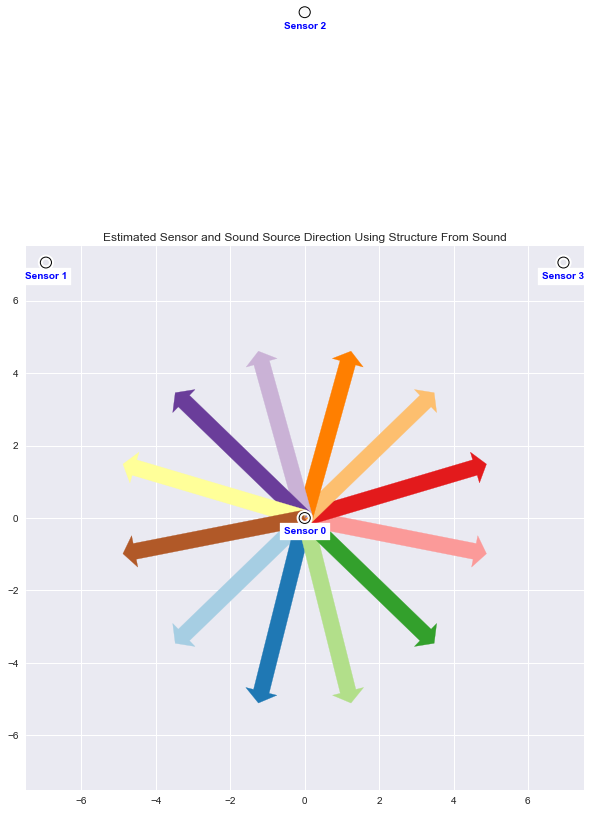

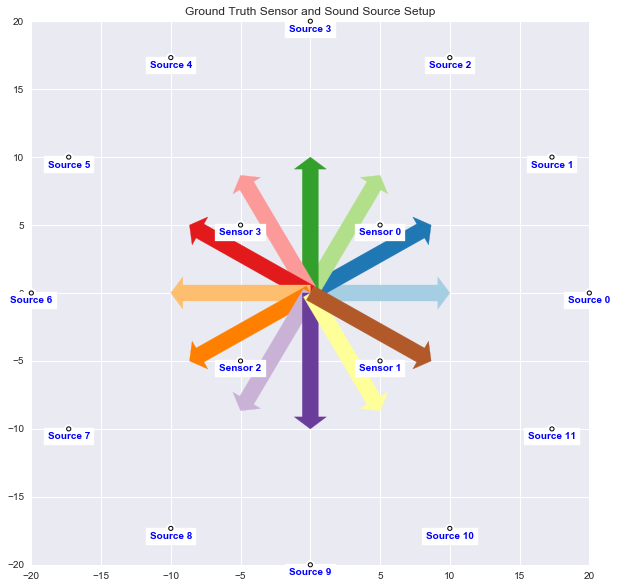

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-7.5, 7.5), ylim=(-7.5, 7.5))

#X contains the estimate of the Sensor locations. 
#x0 is the reference sensor placed at 0,0
x0 = np.zeros((1,2))
#x1 contains the other sensors relative to x0, this is from Eq. 20 for X prime
x1 =  -1* speed_sound* np.matmul(u[:,:2],np.matmul(S, np.linalg.inv(C)))
X = np.concatenate((x0,x1), axis=0)


#Here we plot arrows pointing towards the estimated sound locations starting from the reference sensor
c = plt.cm.Paired
ind = 0
for ind in range(nv.shape[1]):
    #NOTE, not sure why but the x,y coordinates are switched. Take y as the first and x as the second. 
    newy = min(nv[0,ind] * 5, 10)
    newx = min(nv[1,ind] * 5, 10)
    color = c(ind)#[ind%4]
    print newx, newy
    ax.annotate(' ', xy=(newx, newy), xycoords='data',
            xytext=(0, 0), textcoords='data',
            weight=500, color=color,
            arrowprops=dict(width=16, headwidth=32,
                            connectionstyle="arc3",
                            color=color)
           )    

#Plot the Sensors
ind = 0
for y,x in X:
    circle(x,y)
    text(x,(y-0.25),"Sensor {}".format(ind) )
    ind += 1    
    
ax.set_title("Estimated Sensor and Sound Source Direction Using Structure From Sound")     

#Next plot the ground truth    
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, autoscale_on=False, xlim=(-20, 20), ylim=(-20, 20))

ind = 0
for ind in range(Sources.shape[0]):
    newx = Sources[ind,0]  #+ Sensors[0,0]
    newy = Sources[ind,1]  #+ Sensors[0,1]
    color = c(ind)#[ind%4]
    circle(newx , newy)
    text(newx, newy-0.25, "Source {}".format(ind))
    ax.annotate(' ', xy=(newx * 0.5, newy * 0.5), xycoords='data',
            #xytext=(Sensors[0,0], Sensors[0,1]), textcoords='data',
            xytext=(0,0), textcoords='data',
            weight=500, color=color,
            arrowprops=dict(width=16, headwidth=32,
                            connectionstyle="arc3",
                            color=color)
           )    

ind = 0
for x,y in Sensors:
    circle(x,y)
    text(x,y-0.25,"Sensor {}".format(ind) )
    ind += 1

    
ax.set_title("Ground Truth Sensor and Sound Source Setup")



# Now Find Event Locations

In [13]:
'''
This was taking a try at the source distance estimation from SfS

The cost function and derivative calculations are not correct. 
'''

'\nThis was taking a try at the source distance estimation from SfS\n\nThe cost function and derivative calculations are not correct. \n'

In [14]:

def Fxa(A, X, delta):
    fxa = np.zeros(delta.shape)
    for i in range(X.shape[0]):
        x = X[i, :] #/ speed_sound
        for j in range(A.shape[0]):
            a = A[j, :] #/ speed_sound
            x_a_norm = np.linalg.norm(x-a, 2)
            a_norm = np.linalg.norm(a, 2)
            fxa[i, j]= (x_a_norm - a_norm - speed_sound * delta[i,j])
            
    return fxa

In [15]:
def Jxa(A, X, delta):
    Jx = np.zeros((X.shape[0], A.shape[0]))
    Jy = np.zeros((X.shape[0], A.shape[0]))
    Ja = np.zeros((A.shape[0], X.shape[0]))
    Jb = np.zeros((A.shape[0], X.shape[0]))
    M = Fxa(A, X, delta)
    for i in range(X.shape[0]):
        (x, y) = X[i, :] #/ speed_sound
        for j in range(A.shape[0]):
            (a, b) = A[j, :] #/ speed_sound
            xa = (x - a) / np.sqrt((x - a)**2 + (y - b)**2)
            yb = (y - b) / np.sqrt((x - a)**2 + (y - b)**2)
            ab = 1 / np.sqrt(a**2 + b**2)
            dx = 2 * M[i,j] * xa
            dy = 2 * M[i,j] * yb
            da = -2 * M[i, j] * (xa +  a*ab )
            db = -2 * M[i, j] * (yb +  b*ab )
            Jx[i, j] = dx
            Jy[i, j] = dy
            Ja[j, i] = da
            Jb[j, i] = db      
    return(Jx, Jy, Ja, Jb)

In [16]:
X = -1 * speed_sound* np.matmul(u[:,:2],np.matmul(S, np.linalg.inv(C)))
mmax = np.max(np.linalg.norm(X, 2, axis=1)**2)
A = 5*mmax * nv



In [17]:
gamma = 0.005
precision = 1e-9
num_iter = 1000
it = 0
fvals = [100]

#X is the estimate of the Sensor locations
X = -1 * speed_sound* np.matmul(u[:,:2],np.matmul(S, np.linalg.inv(C)))
mmax = np.max(np.linalg.norm(X, 2, axis=1)**2)
#A is the initial estimate of the source location, which is given by Eq. 24
A = 5*mmax * nv


while it < num_iter and fvals[-1] > precision:
    it +=1

    (Jx, Jy, Ja, Jb) = Jxa(A.T, X, dt)
    fxa = Fxa(A.T, X, dt)
    nfxa = fxa ** 2
    dx = np.array([-gamma * np.dot(Jx[i,:],nfxa[i,:]) for i in range(Jx.shape[0])])
    dy = np.array([-gamma * np.dot(Jy[i, :],nfxa[i, :]) for i in range(Jy.shape[0])])
    da = np.array([-gamma * np.dot(Ja[i,:],nfxa[:,i]) for i in range(Ja.shape[0])])
    db = np.array([-gamma * np.dot(Jb[i,:],nfxa[:,i]) for i in range(Jb.shape[0])])
    dX = np.stack((dx,dy), 0)
    dA = np.stack((da, db), 0)
    X += dX.T #speed_sound * dX.T
    A += dA # speed_sound * dA
    
    if it % 10 == 1:
        print "fxa"
        print nfxa
        print "Change in X"
        print dX.T
        print "Change in A"
        print dA.T
        print "Current X"
        print X 
        print "Current A"
        print A.T 
    ffx = np.linalg.norm(fxa, 2)
    fvals.append(ffx)
    print("iter: %s\tFx:%s" % (it, fvals[-1]))

fxa
[[  7.13627877e-03   7.72285567e-01   1.14201014e+00   4.82934295e-02
    5.58186361e-01   3.86926087e-01   3.30139245e-04   8.67182614e-01
    1.26825683e+00   4.82890449e-02   7.75186770e-01   5.24193542e-01]
 [  4.15659363e-02   9.51305132e-04   9.51305132e-04   4.15659363e-02
    3.69560830e-01   2.62209826e-01   1.02573641e-02   1.69001236e-02
    1.69001236e-02   1.02573641e-02   2.62209826e-01   3.69560830e-01]
 [  4.82934295e-02   1.14201014e+00   7.72285567e-01   7.13627877e-03
    5.24193542e-01   7.75186770e-01   4.82890449e-02   1.26825683e+00
    8.67182614e-01   3.30139245e-04   3.86926087e-01   5.58186361e-01]]
Change in X
[[ -2.27996561e-03  -3.63493386e-03]
 [  1.10273043e-04  -8.20454815e-16]
 [ -2.27996561e-03   3.63493386e-03]]
Change in A
[[  6.65096180e-07  -6.67519427e-07]
 [  1.45111820e-06  -4.36557866e-06]
 [  1.45111820e-06   4.36557866e-06]
 [  6.65096180e-07   6.67519427e-07]
 [  2.40955602e-05   4.84237468e-06]
 [  3.41437013e-05  -1.03427178e-05]
 [ -

iter: 43	Fx:3.61945870254
iter: 44	Fx:3.61945100968
iter: 45	Fx:3.61944379109
iter: 46	Fx:3.61943700981
iter: 47	Fx:3.61943063198
iter: 48	Fx:3.61942462658
iter: 49	Fx:3.61941896517
iter: 50	Fx:3.61941362163
fxa
[[  9.71767756e-04   8.34446560e-01   1.16355941e+00   5.77714479e-02
    6.29673315e-01   4.60672730e-01   5.16858873e-03   8.00393773e-01
    1.24759614e+00   5.77704637e-02   7.00708589e-01   4.46320493e-01]
 [  4.30053958e-02   6.79290204e-04   6.79290204e-04   4.30053958e-02
    3.68317609e-01   2.63638295e-01   1.09635409e-02   1.56896564e-02
    1.56896564e-02   1.09635409e-02   2.63638295e-01   3.68317609e-01]
 [  5.77714479e-02   1.16355941e+00   8.34446560e-01   9.71767756e-04
    4.46320493e-01   7.00708589e-01   5.77704637e-02   1.24759614e+00
    8.00393773e-01   5.16858873e-03   4.60672730e-01   6.29673315e-01]]
Change in X
[[ -2.38680349e-05  -1.03687720e-04]
 [  8.68517241e-05  -1.00253139e-15]
 [ -2.38680349e-05   1.03687720e-04]]
Change in A
[[  6.52486345e-07

[[ -1.20512536e-06  -5.69951725e-06]
 [  7.17718628e-05   1.04416475e-15]
 [ -1.20512536e-06   5.69951725e-06]]
Change in A
[[  6.73622693e-07  -6.76109218e-07]
 [  3.25759442e-07   4.16949749e-07]
 [  3.25759442e-07  -4.16949749e-07]
 [  6.73622693e-07   6.76109218e-07]
 [  2.18402351e-05   4.37049252e-06]
 [  3.53604001e-05  -1.06984735e-05]
 [ -6.68782294e-08   6.57959426e-08]
 [  1.67210684e-06  -8.13932320e-06]
 [  1.67210684e-06   8.13932320e-06]
 [ -6.68782294e-08  -6.57959426e-08]
 [  3.53604001e-05   1.06984735e-05]
 [  2.18402351e-05  -4.37049252e-06]]
Current X
[[  7.02557253e+00  -7.01039921e+00]
 [  1.39650218e+01  -2.10875040e-14]
 [  7.02557253e+00   7.01039921e+00]]
Current A
[[-673.47797037 -677.87697987]
 [-994.4891717  -242.37914635]
 [-994.4891717   242.37914635]
 [-673.47797037  677.87697987]
 [-191.88652205  951.74797646]
 [ 289.7272092   951.74660532]
 [ 673.47802362  677.87692631]
 [ 896.65386531  242.37847122]
 [ 896.65386531 -242.37847122]
 [ 673.47802362 -677

iter: 135	Fx:3.61926025232
iter: 136	Fx:3.6192592264
iter: 137	Fx:3.61925820492
iter: 138	Fx:3.61925718783
iter: 139	Fx:3.61925617508
iter: 140	Fx:3.61925516661
fxa
[[  8.93983026e-04   8.35647871e-01   1.16347334e+00   5.81661058e-02
    6.31852736e-01   4.62689074e-01   5.35569071e-03   7.99127336e-01
    1.24772608e+00   5.81651761e-02   6.98466189e-01   4.44273703e-01]
 [  4.49071312e-02   3.94754756e-04   3.94754756e-04   4.49071312e-02
    3.66718791e-01   2.65508394e-01   1.19136343e-02   1.41876023e-02
    1.41876023e-02   1.19136343e-02   2.65508394e-01   3.66718791e-01]
 [  5.81661058e-02   1.16347334e+00   8.35647871e-01   8.93983026e-04
    4.44273703e-01   6.98466189e-01   5.81651761e-02   1.24772608e+00
    7.99127336e-01   5.35569071e-03   4.62689074e-01   6.31852736e-01]]
Change in X
[[ -4.19049291e-08  -1.73288177e-07]
 [  5.65548168e-05   8.35720382e-16]
 [ -4.19049233e-08   1.73288183e-07]]
Change in A
[[  6.95753592e-07  -6.98324871e-07]
 [  3.24123445e-07   4.23821

iter: 238	Fx:3.61917274007
iter: 239	Fx:3.61917203657
iter: 240	Fx:3.61917133538
fxa
[[  8.93667452e-04   8.35651929e-01   1.16347452e+00   5.81671277e-02
    6.31839203e-01   4.62651677e-01   5.35633251e-03   7.99136367e-01
    1.24771545e+00   5.81662000e-02   6.98430562e-01   4.44241803e-01]
 [  4.62777064e-02   2.39762727e-04   2.39762727e-04   4.62777064e-02
    3.65603396e-01   2.66854333e-01   1.26098683e-02   1.31699627e-02
    1.31699627e-02   1.26098683e-02   2.66854333e-01   3.65603396e-01]
 [  5.81671277e-02   1.16347452e+00   8.35651929e-01   8.93667452e-04
    4.44241803e-01   6.98430562e-01   5.81662000e-02   1.24771545e+00
    7.99136367e-01   5.35633251e-03   4.62651677e-01   6.31839203e-01]]
Change in X
[[ -1.06089803e-08  -2.36638062e-08]
 [  3.51003775e-05  -3.05311332e-18]
 [ -1.06089678e-08   2.36638164e-08]]
Change in A
[[  7.27780638e-07  -7.30474572e-07]
 [  3.24078637e-07   4.24015811e-07]
 [  3.24078637e-07  -4.24015811e-07]
 [  7.27780638e-07   7.30474572e-0

iter: 283	Fx:3.61914321094
iter: 284	Fx:3.61914260055
iter: 285	Fx:3.61914199199
iter: 286	Fx:3.61914138526
iter: 287	Fx:3.61914078035
iter: 288	Fx:3.61914017724
iter: 289	Fx:3.61913957594
iter: 290	Fx:3.61913897643
fxa
[[  8.93563218e-04   8.35653109e-01   1.16347519e+00   5.81673502e-02
    6.31830812e-01   4.62631558e-01   5.35651893e-03   7.99141782e-01
    1.24771002e+00   5.81664236e-02   6.98414390e-01   4.44227262e-01]
 [  4.67581155e-02   1.94957089e-04   1.94957089e-04   4.67581155e-02
    3.65222591e-01   2.67330024e-01   1.28561169e-02   1.28255213e-02
    1.28255213e-02   1.28561169e-02   2.67330024e-01   3.65222591e-01]
 [  5.81673502e-02   1.16347519e+00   8.35653109e-01   8.93563218e-04
    4.44227262e-01   6.98414390e-01   5.81664236e-02   1.24771002e+00
    7.99141782e-01   5.35651893e-03   4.62631558e-01   6.31830812e-01]]
Change in X
[[ -1.05381104e-08  -2.35273749e-08]
 [  2.76388230e-05  -2.25375274e-16]
 [ -1.05381122e-08   2.35273706e-08]]
Change in A
[[  7.3912

iter: 376	Fx:3.61909322868
iter: 377	Fx:3.61909275509
iter: 378	Fx:3.61909228265
iter: 379	Fx:3.61909181136
iter: 380	Fx:3.6190913412
fxa
[[  8.93375064e-04   8.35655219e-01   1.16347639e+00   5.81677504e-02
    6.31815658e-01   4.62595405e-01   5.35685394e-03   7.99151536e-01
    1.24770025e+00   5.81668258e-02   6.98385334e-01   4.44201047e-01]
 [  4.73835212e-02   1.43835413e-04   1.43835413e-04   4.73835212e-02
    3.64739720e-01   2.67959261e-01   1.31783910e-02   1.23862647e-02
    1.23862647e-02   1.31783910e-02   2.67959261e-01   3.64739720e-01]
 [  5.81677504e-02   1.16347639e+00   8.35655219e-01   8.93375064e-04
    4.44201047e-01   6.98385334e-01   5.81668258e-02   1.24770025e+00
    7.99151536e-01   5.35685394e-03   4.62595405e-01   6.31815658e-01]]
Change in X
[[ -1.04725330e-08  -2.34777289e-08]
 [  1.79530990e-05  -1.46271883e-16]
 [ -1.04725328e-08   2.34777286e-08]]
Change in A
[[  7.53979485e-07  -7.56773743e-07]
 [  3.24050345e-07   4.24141475e-07]
 [  3.24050345e-07

[[  7.02555234e+00  -7.01048435e+00]
 [  1.39779981e+01  -5.05408881e-14]
 [  7.02555234e+00   7.01048435e+00]]
Current A
[[-673.47766191 -677.87728947]
 [-994.48903557 -242.37896832]
 [-994.48903557  242.37896832]
 [-673.47766191  677.87728947]
 [-191.87724961  951.74983276]
 [ 289.74194407  951.74214643]
 [ 673.47798866  677.87696069]
 [ 896.65456666  242.3750561 ]
 [ 896.65456666 -242.3750561 ]
 [ 673.47798866 -677.87696069]
 [ 289.74194407 -951.74214643]
 [-191.87724961 -951.74983276]]
iter: 511	Fx:3.61903777825
iter: 512	Fx:3.61903741871
iter: 513	Fx:3.61903705977
iter: 514	Fx:3.61903670142
iter: 515	Fx:3.61903634366
iter: 516	Fx:3.61903598649
iter: 517	Fx:3.6190356299
iter: 518	Fx:3.61903527389
iter: 519	Fx:3.61903491846
iter: 520	Fx:3.61903456361
fxa
[[  8.93081292e-04   8.35658483e-01   1.16347824e+00   5.81683738e-02
    6.31792017e-01   4.62539282e-01   5.35737469e-03   7.99166716e-01
    1.24768509e+00   5.81674521e-02   6.98340228e-01   4.44160200e-01]
 [  4.79525642e-02   

iter: 558	Fx:3.61902147914
iter: 559	Fx:3.61902114468
iter: 560	Fx:3.61902081069
fxa
[[  8.92997206e-04   8.35659413e-01   1.16347877e+00   5.81685520e-02
    6.31785253e-01   4.62523265e-01   5.35752341e-03   7.99171054e-01
    1.24768076e+00   5.81676312e-02   6.98327354e-01   4.44148522e-01]
 [  4.80561764e-02   9.77693808e-05   9.77693808e-05   4.80561764e-02
    3.64256239e-01   2.68675355e-01   1.35272435e-02   1.19246152e-02
    1.19246152e-02   1.35272435e-02   2.68675355e-01   3.64256239e-01]
 [  5.81685520e-02   1.16347877e+00   8.35659413e-01   8.92997206e-04
    4.44148522e-01   6.98327354e-01   5.81676312e-02   1.24768076e+00
    7.99171054e-01   5.35752341e-03   4.62523265e-01   6.31785253e-01]]
Change in X
[[ -1.04012481e-08  -2.34229700e-08]
 [  7.51475662e-06  -5.46784840e-17]
 [ -1.04012511e-08   2.34229709e-08]]
Change in A
[[  7.70070456e-07  -7.72926202e-07]
 [  3.24000877e-07   4.24357042e-07]
 [  3.24000877e-07  -4.24357042e-07]
 [  7.70070456e-07   7.72926202e-0

iter: 604	Fx:3.61900655161
iter: 605	Fx:3.61900623675
iter: 606	Fx:3.61900592227
iter: 607	Fx:3.61900560817
iter: 608	Fx:3.61900529444
iter: 609	Fx:3.61900498109
iter: 610	Fx:3.61900466811
fxa
[[  8.92892037e-04   8.35660574e-01   1.16347943e+00   5.81687748e-02
    6.31776796e-01   4.62503253e-01   5.35770929e-03   7.99176476e-01
    1.24767535e+00   5.81678550e-02   6.98311270e-01   4.44133921e-01]
 [  4.81602965e-02   9.14492843e-05   9.14492843e-05   4.81602965e-02
    3.64190213e-01   2.68797275e-01   1.35814793e-02   1.18539918e-02
    1.18539918e-02   1.35814793e-02   2.68797275e-01   3.64190213e-01]
 [  5.81687748e-02   1.16347943e+00   8.35660574e-01   8.92892037e-04
    4.44133921e-01   6.98311270e-01   5.81678550e-02   1.24767535e+00
    7.99176476e-01   5.35770929e-03   4.62503253e-01   6.31776796e-01]]
Change in X
[[ -1.03897602e-08  -2.34132711e-08]
 [  5.88222484e-06  -2.00117700e-15]
 [ -1.03897596e-08   2.34132658e-08]]
Change in A
[[  7.72571474e-07  -7.75436741e-07]


 [ -1.03773883e-08   2.34021156e-08]]
Change in A
[[  7.75187511e-07  -7.78062704e-07]
 [  3.23965598e-07   4.24510231e-07]
 [  3.23965598e-07  -4.24510231e-07]
 [  7.75187511e-07   7.78062704e-07]
 [  2.22110218e-05   4.44748353e-06]
 [  3.48750496e-05  -1.05551359e-05]
 [ -9.45682761e-08   9.30182755e-08]
 [  1.66567195e-06  -8.11585204e-06]
 [  1.66567195e-06   8.11585204e-06]
 [ -9.45682761e-08  -9.30182755e-08]
 [  3.48750496e-05   1.05551359e-05]
 [  2.22110218e-05  -4.44748353e-06]]
Current X
[[  7.02555057e+00  -7.01048833e+00]
 [  1.39791023e+01  -5.35099021e-14]
 [  7.02555057e+00   7.01048833e+00]]
Current A
[[-673.47753074 -677.87742113]
 [-994.48898049 -242.37889617]
 [-994.48898049  242.37889617]
 [-673.47753074  677.87742113]
 [-191.87347494  951.75058859]
 [ 289.74787679  951.7403509 ]
 [ 673.47797276  677.87697634]
 [ 896.65484994  242.373676  ]
 [ 896.65484994 -242.373676  ]
 [ 673.47797276 -677.87697634]
 [ 289.74787679 -951.7403509 ]
 [-191.87347494 -951.75058859]]


iter: 814	Fx:3.61894656569
iter: 815	Fx:3.6189463012
iter: 816	Fx:3.61894603685
iter: 817	Fx:3.61894577263
iter: 818	Fx:3.61894550856
iter: 819	Fx:3.61894524462
iter: 820	Fx:3.61894498082
fxa
[[  8.92449920e-04   8.35665439e-01   1.16348218e+00   5.81697105e-02
    6.31741253e-01   4.62419282e-01   5.35848970e-03   7.99199247e-01
    1.24765265e+00   5.81687953e-02   6.98243777e-01   4.44072590e-01]
 [  4.83995072e-02   7.77245193e-05   7.77245193e-05   4.83995072e-02
    3.64075115e-01   2.69126008e-01   1.37064883e-02   1.16918224e-02
    1.16918224e-02   1.37064883e-02   2.69126008e-01   3.64075115e-01]
 [  5.81697105e-02   1.16348218e+00   8.35665439e-01   8.92449920e-04
    4.44072590e-01   6.98243777e-01   5.81687953e-02   1.24765265e+00
    7.99199247e-01   5.35848970e-03   4.62419282e-01   6.31741253e-01]]
Change in X
[[ -1.03613333e-08  -2.33855605e-08]
 [  2.04098134e-06  -1.48214774e-16]
 [ -1.03613374e-08   2.33855625e-08]]
Change in A
[[  7.78327501e-07  -7.81214510e-07]
 

Current X
[[  7.02554808e+00  -7.01049395e+00]
 [  1.39796769e+01  -5.21892918e-14]
 [  7.02554808e+00   7.01049395e+00]]
Current A
[[-673.47734406 -677.8776085 ]
 [-994.48890275 -242.37879425]
 [-994.48890275  242.37879425]
 [-673.47734406  677.8776085 ]
 [-191.86814422  951.75165599]
 [ 289.75624122  951.73781929]
 [ 673.47794988  677.87699884]
 [ 896.6552495   242.3717289 ]
 [ 896.6552495  -242.3717289 ]
 [ 673.47794988 -677.87699884]
 [ 289.75624122 -951.73781929]
 [-191.86814422 -951.75165599]]
iter: 921	Fx:3.61891893762
iter: 922	Fx:3.61891868483
iter: 923	Fx:3.61891843211
iter: 924	Fx:3.61891817948
iter: 925	Fx:3.61891792694
iter: 926	Fx:3.61891767447
iter: 927	Fx:3.61891742209
iter: 928	Fx:3.61891716979
iter: 929	Fx:3.61891691757
iter: 930	Fx:3.61891666543
fxa
[[  8.92218237e-04   8.35667983e-01   1.16348362e+00   5.81702006e-02
    6.31722635e-01   4.62375338e-01   5.35889833e-03   7.99211171e-01
    1.24764077e+00   5.81692878e-02   6.98208454e-01   4.44040470e-01]
 [  4.8452

iter: 974	Fx:3.61890564606
iter: 975	Fx:3.6189053972
iter: 976	Fx:3.6189051484
iter: 977	Fx:3.61890489967
iter: 978	Fx:3.618904651
iter: 979	Fx:3.6189044024
iter: 980	Fx:3.61890415386
fxa
[[  8.92112927e-04   8.35669138e-01   1.16348428e+00   5.81704233e-02
    6.31714173e-01   4.62355370e-01   5.35908404e-03   7.99216590e-01
    1.24763537e+00   5.81695116e-02   6.98192404e-01   4.44025873e-01]
 [  4.84675748e-02   7.40001060e-05   7.40001060e-05   4.84675748e-02
    3.64080605e-01   2.69271025e-01   1.37423363e-02   1.16449076e-02
    1.16449076e-02   1.37423363e-02   2.69271025e-01   3.64080605e-01]
 [  5.81704233e-02   1.16348428e+00   8.35669138e-01   8.92112927e-04
    4.44025873e-01   6.98192404e-01   5.81695116e-02   1.24763537e+00
    7.99216590e-01   5.35908404e-03   4.62355370e-01   6.31714173e-01]]
Change in X
[[ -1.03510509e-08  -2.33719291e-08]
 [  8.48162327e-07  -6.60582700e-17]
 [ -1.03510467e-08   2.33719316e-08]]
Change in A
[[  7.79967562e-07  -7.82860586e-07]
 [  3

In [18]:
print Jx
print "---"
print Jy
print "---"
print Ja
print "---"
print Jb



[[ 0.04253925 -1.77980966 -2.09337292  0.33999074  0.32288372 -0.38466214
  -0.10210741  1.72161758  2.15964913  0.33995764 -0.47913728  0.27454824]
 [ 0.31353601 -0.01669934 -0.01669934  0.31353601 -0.25510711  0.28885073
   0.16350612 -0.20809017 -0.20809017  0.16350612  0.28885073 -0.25510711]
 [ 0.33999074 -2.09337292 -1.77980966  0.04253925  0.27454824 -0.47913728
   0.33995764  2.15964913  1.72161758 -0.10210741 -0.38466214  0.32288372]]
---
[[ 0.04193691 -0.41827726  0.52127528 -0.34218172 -1.55646713 -1.30438728
  -0.10493186  0.48260492 -0.57135709 -0.34220928  1.60099116  1.30411064]
 [ 0.30916705 -0.00401358  0.00401358 -0.30916705  1.17951533  0.99684791
   0.16806269 -0.05713882  0.05713882 -0.16806269 -0.99684791 -1.17951533]
 [ 0.34218172 -0.52127528  0.41827726 -0.04193691 -1.30411064 -1.60099116
   0.34220928  0.57135709 -0.48260492  0.10493186  1.30438728  1.55646713]]
---
[[ -4.37861522e-04  -3.19233674e-03  -1.52264752e-05]
 [  3.50593160e-03   1.28947419e-05  -2.57

In [19]:
print dt * speed_sound

[[  0.           6.11478097   9.57725154   9.68370927   7.48126654
    4.01879598   0.          -4.01879598  -7.48126654  -9.68370927
   -9.57725154  -6.11478097]
 [  9.68370927  13.59604751  13.59604751   9.68370927   3.46247057
   -3.46247057  -9.68370927 -13.59604751 -13.59604751  -9.68370927
   -3.46247057   3.46247057]
 [  9.68370927   9.57725154   6.11478097   0.          -6.11478097
   -9.57725154  -9.68370927  -7.48126654  -4.01879598   0.           4.01879598
    7.48126654]]


In [20]:
print X

[[  7.02554726e+00  -7.01049579e+00]
 [  1.39797527e+01  -4.52576143e-14]
 [  7.02554726e+00   7.01049579e+00]]


In [21]:
print A.T

[[-673.47728246 -677.87767033]
 [-994.48887716 -242.37876069]
 [-994.48887716  242.37876069]
 [-673.47728246  677.87767033]
 [-191.86638994  951.75200725]
 [ 289.75899253  951.73698654]
 [ 673.47794231  677.87700629]
 [ 896.65538095  242.37108827]
 [ 896.65538095 -242.37108827]
 [ 673.47794231 -677.87700629]
 [ 289.75899253 -951.73698654]
 [-191.86638994 -951.75200725]]


In [22]:
print nfxa

[[  8.92072911e-04   8.35669578e-01   1.16348453e+00   5.81705079e-02
    6.31710958e-01   4.62347784e-01   5.35915460e-03   7.99218649e-01
    1.24763332e+00   5.81695966e-02   6.98186306e-01   4.44020327e-01]
 [  4.84722734e-02   7.37442156e-05   7.37442156e-05   4.84722734e-02
    3.64084012e-01   2.69285124e-01   1.37448298e-02   1.16415909e-02
    1.16415909e-02   1.37448298e-02   2.69285124e-01   3.64084012e-01]
 [  5.81705079e-02   1.16348453e+00   8.35669578e-01   8.92072911e-04
    4.44020327e-01   6.98186306e-01   5.81695966e-02   1.24763332e+00
    7.99218649e-01   5.35915460e-03   4.62347784e-01   6.31710958e-01]]


In [23]:
(x,y) = X[0,:]
print x,y

7.02554726314 -7.01049579176


In [24]:
(a,b) = A[:,0]
print a,b

-673.477282459 -677.877670333


In [25]:
print np.linalg.norm(X[0,:]-A[:,0].T, 2)
print np.linalg.norm(A[:,0], 2)
print dt[0,0] * speed_sound

955.587184477
955.557316923
0.0
